In [6]:
import os
import time
 
import matplotlib.pyplot as plt
import torch
import torchx
from PIL import Image
from tqdm.notebook import tqdm

from FastSCNN import AudiDataset, FastSCNN

# Parameters

In [7]:
params = torchx.params.Parameters("params.yml")

In [8]:
if params.crop_height * 2 != params.crop_width:
    raise AssertionError("Crop width must be exactly twice the size of crop height")

In [9]:
log = params.get_logger('FastSCNN')

# Dataset

In [10]:
training_dataloader = torch.utils.data.DataLoader(
    AudiDataset(960, 1920, 0.5, "train"),
    batch_size  = params.batch_size,
    num_workers = 12,
    shuffle     = False,
    drop_last   = True
)

td = iter(training_dataloader)

In [12]:
%%timeit
image, label = next(td)

KeyboardInterrupt: 

In [22]:
j = 0
def timeit():
    global j
    for i in range(16):
        image, label = dataset[j]
        j += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


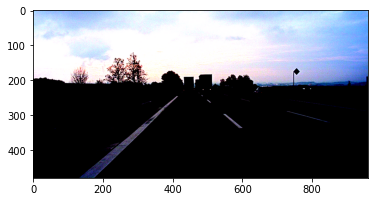

In [38]:
plt.imshow(np.moveaxis(image.numpy(), 0, -1))

In [5]:
# Check to see if all required paths are present
if not os.path.join("data", "class_list.json"):
    raise AssertionError(os.path.join("data", "class_list.json") + " does not exist")

for directory in ("train", "train_labels", "test", "test_labels", "val", "val_labels"):
    if not os.path.isdir(os.path.join("data", directory)):
        raise AssertionError(os.path.join("data", directory) + " does not exist")

In [6]:
num_classes = 2 if params.single_class else len(Dataset.classes)+1

## Training Dataset

In [48]:
training_dataloader = torch.utils.data.DataLoader(
    Dataset(
        params.crop_height,
        params.crop_width,
        params.resize_scale,
        mode="train",
        single_class = params.single_class
    ),
    batch_size  = params.batch_size,
    num_workers = params.num_workers,
    shuffle     = True,
    drop_last   = True
)

## Validation Dataset

In [8]:
val_dataset = Dataset(
    params.crop_height,
    params.crop_width,
    params.resize_scale,
    mode="val",
    single_class = params.single_class
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size  = 1,
    num_workers = params.num_workers,
    shuffle     = True
)

num_validation = min(params.num_validation, len(val_dataloader))

# Train

In [9]:
device = torch.device("cuda:"+params.cuda if params.use_gpu else "cpu")

def to_device(tensor):
    if params.use_gpu:
#         torch.nn.DataParallel(model).cuda()
#         tensor.cuda()
        return tensor.to(device)
    else:
        return tensor

In [10]:
model = FastSCNN(image_height   = int(params.crop_height * params.resize_scale),
                 image_width    = int(params.crop_width * params.resize_scale),
                 image_channels = 3,
                 num_classes    = num_classes)
model = to_device(model)

In [11]:
model.num_params()

1141462

In [15]:
with torch.no_grad():
    model.eval()
    
    for image, label in training_dataloader:
        image = to_device(image)
        output = model.forward(image)
        break
    
    model.train()

In [12]:
# load pretrained model if exists
if params.pretrained_model_path is not None:
    print('loading model from %s ...' % pretrained_model_path)
    model.load(params.pretrained_model_path)

## Validation

In [13]:
data, label = next(iter(val_dataloader))
data = to_device(data)
output = model.forward(data)

In [14]:
flattened_output = output.argmax(dim=1).detach().cpu().numpy()
flattened_label = label.numpy()

In [15]:
def compute_hist(a, b, n):
	k = (a >= 0) & (a < n)
	return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

iou_per_class = lambda hist: (np.diag(hist) + 1e-5) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + 1e-5)

def validation(model, dataloader):

    with torch.no_grad(), tqdm(total=num_validation, position=0, leave=False) as val_progress:
        model.eval()
        
        precisions = []
        hist = np.zeros((num_classes, num_classes))

        for i, (data, label) in enumerate(dataloader):
            
            data = to_device(data)
                
            output = model(data).argmax(dim=1).detach().cpu().numpy()
            label = label.numpy()

            precisions.append(np.sum(output == label) / np.prod(label.shape))
            hist += compute_hist(output.flatten(), label.flatten(), num_classes)
            
            val_progress.set_postfix(precision='%.6f' % np.mean(precisions))
            val_progress.update()
            
            if i >= num_validation:
                break
            
            if len(precisions) > num_validation:
                raise AssertionError("Validating more than wanted")
        
        precision = np.mean(precisions)
        iou = iou_per_class(hist)[:-1]
        miou = np.mean(iou)
    
    return precision, miou, iou

## Training Loop

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [17]:
with open(params.log_file, "w") as file:
    pass

In [ ]:
model_suffix = ""

best_mean_loss = np.inf
best_mIoU, best_precision, iou = validation(model, val_dataloader)
log.info(f"Initial: mIoU {best_mIoU}, precision {best_precision}")

with PolyLearningRateDecay(
    optimizer,
    power=4,
    max_decay_steps=50,
    final_learning_rate=0.00005
) as scheduler:
    
    for epoch in trange(params.epoch_start, params.num_epochs + 1, leave=False):
        
        with tqdm(total=len(train_dataloader) // params.batch_size, position=0, leave=False) as progress, \
            LossAccumulator(optimizer, 4) as lossAccumulator:
            model.train()
            
            progress.set_description('epoch %d, lr %f' % (epoch, scheduler.learning_rate))

            cumulative_loss = 0
            for i, (images, labels) in enumerate(training_dataloader):

                images = to_device(images)
                labels = to_device(labels)

                output = model.forward(images)
                loss = criterion(output, labels)
                cumulative_loss += loss.item()
                
                info = f"Epoch {epoch}, lr {scheduler.learning_rate}, i {i}, loss {loss.item()}"
                if np.isnan(loss.item()):
                    log.warning(info)
                    break
                else:
                    log.info(info)

                loss.backward()

                progress.set_postfix(loss='%.6f' % loss.item())
                progress.update()

                next(lossAccumulator)

            if epoch % params.checkpoint_step == 0:
                model.save(os.path.join(params.save_model_path, f'latest_{params.model_suffix}.pt'))

            mean_loss = cumulative_loss / len(train_dataloader)
            log.info(f"Epoch {epoch}, mean loss {mean_loss}")

            if mean_loss < best_mean_loss:
                best_mean_loss = mean_loss
                model.save(os.path.join(params.save_model_path, f'min_loss_{params.model_suffix}.pt'))

            if epoch % params.validation_step == 0:
                mIoU, precision, iou = validation(model, val_dataloader)
                log.info(f"Epoch {epoch}, mIoU {mIoU}, precision {precision}")
                if mIoU > best_mIoU:
                    best_mIoU = mIoU
                    model.save(os.path.join(params.save_model_path, f'best_miou_{params.model_suffix}.pt'))
                if precision > best_:
                    best_ = precision
                    model.save(os.path.join(params.save_model_path, f'best_precision_{params.model_suffix}.pt'))